In [1]:
import torch

In [2]:
! ls

configs		     q5_train_atari_linear.py
core		     q6_train_atari_nature.py
detector.ipynb	     requirements.txt
object_extractor.py  results
optional_yaml	     SamplePerformanceAfterAFewMillionTraining.mp4
__pycache__	     SamplePerformanceBeforeTraining.mp4
q2_schedule.py	     tensor.pt
q3_linear_torch.py   utils
q4_nature_torch.py   weights


In [3]:
frames = torch.load('tensor.pt').cpu()

In [4]:
frames.size()

torch.Size([10000, 210, 160, 3])

In [5]:
import matplotlib.pyplot as plt
# plt.imshow(frames[13].cpu()

In [6]:
# from torch import torchvision
# model = torchvision.models.detection.maskrcnn_resnet50_fpn()
# model.eval()
# predictions = model(frames)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [8]:
torch.cuda.empty_cache()
# print(torch.cuda.memory_summary(device=device))

assert torch.cuda.is_available()

# x = frames[0].permute(2,0,1).float()#.to(device)
x = frames[:10].permute(0,3,1,2).float()#.to(device)

import torchvision
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)#.to(device)
# model = model.to(device)

# next(model.parameters()).device
# predictions = model(x)
predictions = model(x)

In [9]:
frames[0].shape

torch.Size([210, 160, 3])

In [10]:
# x.get_device()
# x.device

In [11]:
frames = frames.cpu()

In [12]:
torch.cuda.empty_cache()

In [13]:
torch.cuda.get_device_capability()

(7, 5)

In [14]:
print(torch.cuda.memory_summary(device=device))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |     962 MB |     962 MB |     962 MB |
|       from large pool |       0 B  |     962 MB |     962 MB |     962 MB |
|       from small pool |       0 B  |       0 MB |       0 MB |       0 MB |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |     962 MB |     962 MB |     962 MB |
|       from large pool |       0 B  |     962 MB |     962 MB |

In [15]:
output_predictions = predictions['out'][0].argmax(0)

In [16]:
frames[0].cpu().numpy().shape

(210, 160, 3)

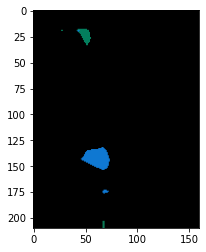

In [17]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

from PIL import Image

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy())#.resize((210, 160,))
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(r)
plt.show()


In [18]:
# (N, 21, H, W)
predictions['out'].shape

torch.Size([10, 21, 210, 160])

In [19]:
# for i in range(100):
#     plt.imshow(predictions['out'][0].argmax(0).byte().cpu().numpy())
#     plt.show()

In [20]:
import numpy as np
from skimage import data
from skimage import filters
n = 20
l = 256
im = np.zeros((l, l))
points = l * np.random.random((2, n ** 2))
im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
im = filters.gaussian(im, sigma=l / (4. * n))
blobs = im > im.mean()

In [21]:
blobs.shape

(256, 256)

In [22]:
from skimage import measure

all_labels = measure.label(frames[0].cpu().numpy(), return_num=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


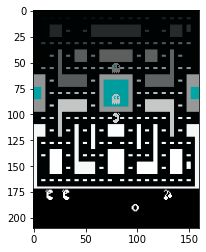

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 2, 2],
        [1, 2, 2],
        [1, 2, 2],
        ...,
        [1, 2, 2],
        [1, 2, 2],
        [1, 2, 2]],

       [[1, 2, 2],
        [1, 2, 2],
        [1, 2, 2],
        ...,
        [1, 2, 2],
        [1, 2, 2],
        [1, 2, 2]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]])

In [23]:
plt.imshow(all_labels[0])
plt.show()
all_labels[0]

In [24]:
# plt.imshow(all_labels, cmap='nipy_spectral')

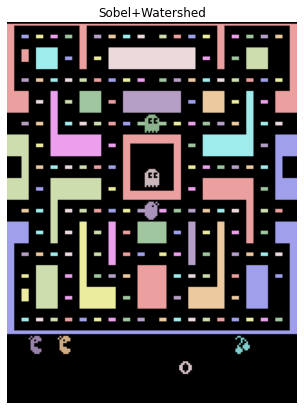

In [25]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import sobel
from skimage.measure import label
from skimage.segmentation import watershed#, expand_labels
from skimage.color import label2rgb
from skimage import data

coins = frames[1].cpu().numpy()[:,:,0]#data.coins()

# Make segmentation using edge-detection and watershed.
edges = sobel(coins)

# Identify some background and foreground pixels from the intensity values.
# These pixels are used as seeds for watershed.
markers = np.zeros_like(coins)
foreground, background = 1, 2
markers[coins < 30.0] = background
markers[coins > 150.0] = foreground

ws = watershed(edges, markers)
seg1 = label(ws == foreground)

# Show the segmentations.
plt.figure(figsize=(14, 7))
color1 = label2rgb(seg1, image=coins, bg_label=0)
plt.imshow(color1)
plt.title('Sobel+Watershed')
plt.axis('off')
plt.show()

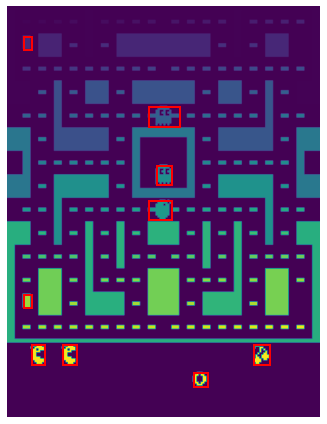

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(seg1)
import matplotlib.patches as mpatches
from skimage.measure import regionprops
for region in regionprops(seg1):
    # take regions with large enough areas
    if region.area >= 10 and region.area < 90:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
ax.set_axis_off()
plt.tight_layout()
plt.show()

(210, 160)

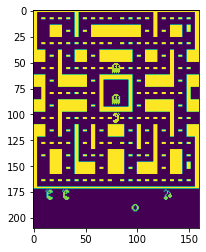

In [27]:
plt.imshow(frames[0].cpu().numpy()[:,:,0])
frames[0].cpu().numpy()[:,:,0].shape

In [28]:
pacman = frames[0].cpu().numpy()[:,:,0]

In [29]:
# import cv2
# num_labels, labels_im = cv2.connectedComponents(img)

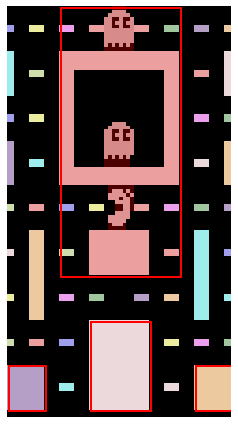

In [36]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb


image = pacman[50:-50, 50:-50]

# apply threshold
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(3))

# remove artifacts connected to image border
cleared = bw#clear_border(bw)

# label image regions
label_image = label(cleared)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [31]:
img = frames[0,:,:,0].cpu().numpy()
img.shape

(210, 160)

In [32]:
import cv2
import numpy as np
import tensorflow as tf

# img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)#cv2.imread(frames[0])
# img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary
num_labels, labels_im = cv2.connectedComponents(img)


# Map component labels to hue val
label_hue = np.uint8(179*labels_im/np.max(labels_im))
blank_ch = 255*np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

# cvt to BGR for display
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

# set bg label to black
labeled_img[label_hue==0] = 0

cv2.imshow('labeled.png', labeled_img)
cv2.waitKey()
cv2.destroyAllWindows()

In [33]:
num_labels

181

In [34]:
labels_im.shape

(210, 160)